# Tensorflow 2.x - Linear Regression

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

from scipy import stats
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor

warnings.filterwarnings(action='ignore')

In [50]:
df = pd.read_csv('data/ozone.csv')
display(df.head(), df.shape)

x_data = df[['Solar.R', 'Wind', 'Temp']] # 독립변수
t_data = df['Ozone'] # 종속변수

display(x_data.head())
display(t_data.head())

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5


(153, 6)

,Solar.R,Wind,Temp
0,190.0,7.4,67
1,118.0,8.0,72
2,149.0,12.6,74
3,313.0,11.5,62
4,NaN,14.3,56


0    41.0
1    36.0
2    12.0
3    18.0
4     NaN
Name: Ozone, dtype: float64

## 데이터 전처리
### 1. 독립변수에 대한 결측치 처리

In [51]:
# 결측치 확인
print(x_data.isnull().sum())

# 중앙값으로 대체
for col in x_data.columns: # Solar, Wind, Temp
    col_median = np.nanmedian(x_data[col]) # 해당 컬럼의 중앙값
    x_data[col].loc[x_data[col].isnull()] = col_median

display(x_data.isnull().sum())

Solar.R    7
Wind       0
Temp       0
dtype: int64


Solar.R    0
Wind       0
Temp       0
dtype: int64

### 2. 독립변수에 대한 이상치 처리

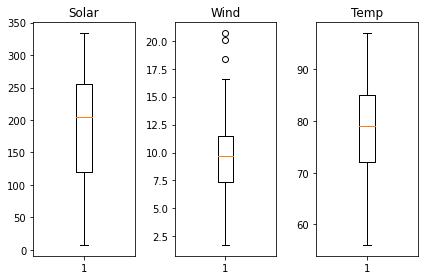

In [52]:
# 이상치 확인
fig = plt.figure()
fig_1 = fig.add_subplot(1,3,1)
fig_2 = fig.add_subplot(1,3,2)
fig_3 = fig.add_subplot(1,3,3)

fig_1.set_title('Solar')
fig_1.boxplot(x_data['Solar.R'])
fig_2.set_title('Wind')
fig_2.boxplot(x_data['Wind'])
fig_3.set_title('Temp')
fig_3.boxplot(x_data['Temp'])

fig.tight_layout()
plt.show()

In [42]:
# 평균값으로 대체
zscore_threshold = 1.8 # z-score outlier 임계값

for col in x_data.columns: # Solar, Wind, Temp
    outlier = x_data[col][(np.abs(stats.zscore(x_data[col])) > zscore_threshold)]
    col_mean = np.mean(x_data.loc[~x_data[col].isin(outlier), col]) 
    print(col_mean) # 이상치를 제외한 각 컬럼에 대한 평균값
    
    # 이상치 대체
    x_data.loc[x_data[col].isin(outlier), col] = col_mean 

198.6013986013986
9.820279720279721
78.75524475524476


### 3. 종속변수에 대한 이상치 처리

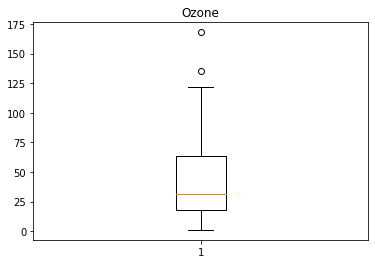

42.12931034482759


In [59]:
# 이상치 확인
plt.boxplot(t_data.dropna())
plt.title('Ozone')
plt.show()

# 평균값으로 대체
zscore_threshold = 1.8
outlier = t_data[(np.abs(stats.zscore(t_data)) > zscore_threshold)] 
col_mean = np.mean(t_data[~t_data.isin(outlier)]) 
print(col_mean)

t_data[t_data.isin(outlier)] = col_mean 

### 4. 정규화 진행

In [60]:
# 독립변수 정규화
scaler_x = MinMaxScaler()
scaler_x.fit(x_data.values) # ndarray 2차원 행렬
x_data_norm = scaler_x.transform(x_data.values)


# 종속변수 정규화
scaler_t = MinMaxScaler()
scaler_t.fit(t_data.values.reshape(-1,1)) # (나중에 행렬곱 연산을 위해) 1차원 벡터를 2차원 행렬로 변환 
t_data_norm = scaler_t.transform(t_data.values.reshape(-1,1)).ravel() # (sklearn 인자로 사용하기 위해) 다시 1차원 벡터로 변환

### 5. 종속변수에 대한 결측치 처리

In [61]:
# KNN 학습에 사용될 데이터
x_data_train_norm = x_data_norm[~np.isnan(t_data_norm)] 
t_data_train_norm = t_data_norm[~np.isnan(t_data_norm)]

# Model
knn_regressor = KNeighborsRegressor(n_neighbors=2)
knn_regressor.fit(x_data_train_norm, t_data_train_norm)

# Prediction
# 종속변수가 NaN인 독립변수에 대한 종속변수 예측
knn_predict = knn_regressor.predict(x_data_norm[np.isnan(t_data_norm)])

# 종속변수의 결측치를 예측값으로 대체
t_data_norm[np.isnan(t_data_norm)] = knn_predict

## Prediction

In [62]:
test_data = [[310, 15, 80]]

# test_data 정규화
result = scaler_x.transform(test_data)

## Scikit-learn

In [63]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_data_norm, t_data_norm)

# prediction
sk_result = model.predict(result) # 1차원
print('sklearn 예측값: {}'.format(scaler_t.inverse_transform(sk_result.reshape(-1,1)))) # inverse_transform(2차원)

sklearn 예측값: [[38.48758115]]


## Keras

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

# Keras Model
keras_model = Sequential()

# Layers(W, b)
keras_model.add(Flatten(input_shape=(3,))) # 데이터 1개의 shape, 입력으로 들어오는 데이터를 1차원으로 변경
keras_model.add(Dense(1, activation='linear')) # Linear Regression

# Optimizer
keras_model.compile(optimizer=SGD(learning_rate=1e-2), loss='mse')

# Learning
keras_model.fit(x_data_norm, t_data_norm,
                epochs=5000, verbose=0)

# Prediction
keras_result = keras_model.predict(scaler_x.transform(test_data))
print('keras 예측값: {}'.format(scaler_t.inverse_transform(keras_result.reshape(-1,1)))) # inverse_transform(2차원)

keras 예측값: [[38.61291]]


# Tensorflow 2.x - Logistic Regression

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

## Feature Engineering

In [31]:
df = pd.read_csv('data/titanic/train.csv')

# 1. 필요없는 column 삭제
df = df.drop(df[['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin']], 
             axis=1, inplace=False)

# 2. 새로운 column 생성
df['Family'] = df['SibSp'] + df['Parch']
df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# 3. 문자 -> 숫자
sex_dict = {'male': 0, 'female': 1}
df['Sex'] = df['Sex'].map(sex_dict) # Series.map()

embarked_dict = {'S': 0, 'C': 1, 'Q': 2}
df['Embarked'] = df['Embarked'].map(embarked_dict)

display(df)

# 4. binning 처리 (연속적인 숫자값 -> Categorical value)
def age_category(age):
    if (age >= 0) & (age < 25):
        return 0
    elif (age >= 25) & (age < 50):
        return 1
    else:
        return 2

df['Age'] = df['Age'].map(age_category)
display(df)

,Survived,Pclass,Sex,Age,Embarked,Family
0,0,3,0,22.0,0.0,1
1,1,1,1,38.0,1.0,1
2,1,3,1,26.0,0.0,0
3,1,1,1,35.0,0.0,1
4,0,3,0,35.0,0.0,0
...,...,...,...,...,...,...
886,0,2,0,27.0,0.0,0
887,1,1,1,19.0,0.0,0
888,0,3,1,NaN,0.0,3
889,1,1,0,26.0,1.0,0


,Survived,Pclass,Sex,Age,Embarked,Family
0,0,3,0,0,0.0,1
1,1,1,1,1,1.0,1
2,1,3,1,1,0.0,0
3,1,1,1,1,0.0,1
4,0,3,0,1,0.0,0
...,...,...,...,...,...,...
886,0,2,0,1,0.0,0
887,1,1,1,0,0.0,0
888,0,3,1,2,0.0,3
889,1,1,0,1,1.0,0


## 데이터 전처리

### 결측치 처리

In [34]:
# Age(중앙값)
df.loc[df['Age'].isnull(), 'Age'] = np.nanmedian(df['Age'].values) # Series = Series

# Embarked(최빈값)
embarked_mode = df['Embarked'].mode()[0]
print(embarked_mode)
display(df.loc[df['Embarked'].isnull(), 'Embarked'])

df.loc[df['Embarked'].isnull(), 'Embarked'] = embarked_mode
display(df.loc[df['Embarked'].isnull(), 'Embarked'])

0.0


61    NaN
829   NaN
Name: Embarked, dtype: float64

Series([], Name: Embarked, dtype: float64)

### Split Data

In [72]:
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df.drop('Survived', axis=1, inplace=False),
                 df['Survived'], test_size=0.3, random_state=0)

### 정규화 처리

In [73]:
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)

scaler.fit(x_data_test)
x_data_test_norm = scaler.transform(x_data_test)

## Scikit-learn

In [74]:
model = LogisticRegression()
model.fit(x_data_train_norm, t_data_train)

# accuracy (성능평가)
sk_result = model.score(x_data_test_norm, t_data_test)
print('sklearn의 accuracy: {}'.format(sk_result)) # 0.8097014925373134

sklearn의 accuracy: 0.8097014925373134


## Keras

In [75]:
# model
keras_model = Sequential()

# layers

keras_model.add(Flatten(input_shape=(x_data_train_norm.shape[1],)))
keras_model.add(Dense(1, activation='sigmoid')) # Logistic

# optimizer
keras_model.compile(optimizer=SGD(learning_rate=1e-2),
                    loss='binary_crossentropy', metrics=['accuracy'])

# learning
keras_model.fit(x_data_train_norm, t_data_train, epochs=1000, verbose=0)

# accuracy (성능평가)
keras_result = keras_model.evaluate(x_data_test_norm, t_data_test)
print('keras의 accuracy: {}'.format(keras_result)) # binary - 0 or 1 # 0.8097015023231506

9/9 [==============================] - 0s 574us/step - loss: 0.4491 - accuracy: 0.8097
keras의 accuracy: [0.4490669369697571, 0.8097015023231506]


# Tensorflow 2.x - Multinomial Classification

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')

## Raw Data

In [12]:
df = pd.read_csv('data/mnist/train.csv')
display(df.head(), df.shape)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(42000, 785)

## Feature Engineering

In [13]:
x_data = df.drop('label', axis=1, inplace=False) # DataFrame
t_data = df['label'] # DataFrame, one-hot(X)

## 정규화 처리

In [14]:
scaler = MinMaxScaler()
scaler.fit(x_data) # fit(2차원 ndarray)
x_data_norm = scaler.transform(x_data)

## 데이터 분리

In [15]:
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(x_data_norm, t_data, test_size=0.3, random_state=0)

## Scikit-learn
Scikit-learn에서는 `t_data`(종속변수)의 One-hot Encoding 처리를 안해도 된다.

In [7]:
sklearn_model = LogisticRegression(solver='saga')
sklearn_model.fit(x_data_train, t_data_train)

predict_data = sklearn_model.predict(x_data_test)

result = classification_report(t_data_test, predict_data) # (정답, 예측값)
print(result)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1242
           1       0.95      0.97      0.96      1429
           2       0.92      0.90      0.91      1276
           3       0.91      0.90      0.91      1298
           4       0.92      0.92      0.92      1236
           5       0.88      0.88      0.88      1119
           6       0.93      0.95      0.94      1243
           7       0.94      0.93      0.94      1334
           8       0.89      0.88      0.88      1204
           9       0.89      0.89      0.89      1219

    accuracy                           0.92     12600
   macro avg       0.92      0.92      0.92     12600
weighted avg       0.92      0.92      0.92     12600



In [9]:
%reset # 메모리 삭제

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Keras
tensorflow 2.x 버전에서는 설정만 잡아주면 종속변수의 One-hot Encoding 처리를 해줄 필요가 없다.

In [19]:
# model
keras_model = Sequential()

# layers
keras_model.add(Flatten(input_shape=(x_data_train.shape[1],))) # 1차원
keras_model.add(Dense(10, activation='softmax')) # multinomial classification

# optimizer
keras_model.compile(optimizer=SGD(learning_rate=1e-1), 
                    loss='sparse_categorical_crossentropy', # one-hot(X)
                    metrics=['sparse_categorical_accuracy']) 

# learning
# 추후에 history 객체를 이용해서 hyper parameter인 epoch수를 조절할 수 있다.
history = keras_model.fit(x_data_train, t_data_train, 
                          epochs=100, batch_size=512, 
                          verbose=0, validation_split=0.2) 

# evaluation
result = keras_model.evaluate(x_data_test, t_data_test)
print(result)

394/394 [==============================] - 0s 733us/step - loss: 0.2960 - sparse_categorical_accuracy: 0.9180
[0.29596641659736633, 0.9180158972740173]


### 학습과정에서 나온 결과 객체

<class 'dict'>
dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


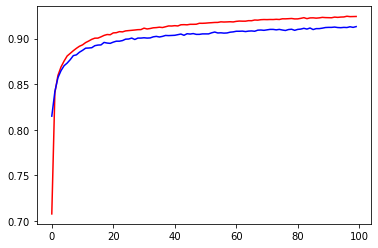

In [28]:
print(type(history.history))  # <class 'dict'>
print(history.history.keys()) # 'loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'

# 에폭당 accuracy 값에 대한 그래프
plt.plot(history.history['sparse_categorical_accuracy'], color='r') # training_data를 이용한 정확도

plt.plot(history.history['val_sparse_categorical_accuracy'], color='b') # validation_data를 이용한 정확도
plt.show()